In [96]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [97]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [98]:
df = pd.read_csv('/content/sample_data/cabbage_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [99]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.tail()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
2390,2022-09-26,0.0,1.7,2.5,8.7,8547.0,2017507,0,0,0,0
2391,2022-09-27,0.0,1.6,2.5,8.7,8196.0,2017507,1,0,0,0
2392,2022-09-28,0.0,1.8,2.5,8.7,7912.0,2017507,0,1,0,0
2393,2022-09-29,0.0,1.4,2.5,8.7,8052.0,2017507,0,0,1,0
2394,2022-09-30,0.0,1.6,2.5,8.7,8112.0,2017507,0,0,0,1


In [100]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]

scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.22860209 0.         0.61403509 ... 1.         0.         0.        ]
 [0.2345944  0.         0.36842105 ... 0.         1.         0.        ]
 [0.23119578 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.56882211 0.         0.19298246 ... 1.         0.         0.        ]
 [0.58134335 0.         0.12280702 ... 0.         1.         0.        ]
 [0.5867096  0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [101]:
# 7일치의 input으로 7일치의 output을 생산
seq_length = 7
predict_day = 7
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2381
2381


In [102]:
# 7의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1428
validation_size = 476
test_size = 476

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1428, 7, 10)
(1428, 7, 1)
(476, 7, 10)
(476, 7, 1)
(476, 7, 10)
(476, 7, 1)


In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [104]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [106]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(7, 7, input_columns), return_sequences=True, stateful=True, dropout=0.1))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.1))
model.add(Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (7, 7, 16)                1728      
                                                                 
 lstm_9 (LSTM)               (7, 7, 16)                2112      
                                                                 
 dense_4 (Dense)             (7, 7, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [115]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-cabbage.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [116]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [117]:
custom_hist = CustomHistory()
custom_hist.init()

In [118]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=7, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
204/204 - 4s - loss: 0.0024 - mae: 0.0342 - val_loss: 0.0117 - val_mae: 0.0617 - 4s/epoch - 20ms/step
epochs:1
204/204 - 1s - loss: 0.0025 - mae: 0.0359 - val_loss: 0.0082 - val_mae: 0.0551 - 1s/epoch - 6ms/step
epochs:2
204/204 - 1s - loss: 0.0025 - mae: 0.0354 - val_loss: 0.0126 - val_mae: 0.0662 - 1s/epoch - 5ms/step
epochs:3
204/204 - 1s - loss: 0.0032 - mae: 0.0400 - val_loss: 0.0078 - val_mae: 0.0553 - 1s/epoch - 6ms/step
epochs:4
204/204 - 2s - loss: 0.0024 - mae: 0.0344 - val_loss: 0.0121 - val_mae: 0.0646 - 2s/epoch - 11ms/step
epochs:5
204/204 - 1s - loss: 0.0025 - mae: 0.0349 - val_loss: 0.0079 - val_mae: 0.0498 - 1s/epoch - 7ms/step
epochs:6
204/204 - 1s - loss: 0.0024 - mae: 0.0343 - val_loss: 0.0061 - val_mae: 0.0472 - 1s/epoch - 6ms/step
epochs:7
204/204 - 1s - loss: 0.0024 - mae: 0.0345 - val_loss: 0.0078 - val_mae: 0.0542 - 1s/epoch - 5ms/step
epochs:8
204/204 - 1s - loss: 0.0024 - mae: 0.0350 - val_loss: 0.0097 - val_mae: 0.0592 - 1s/epoch - 6ms/step
epochs:9

In [119]:
a = 7

In [120]:
model.evaluate(trainX, trainY, batch_size = a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0028 - mae: 0.0357


[0.0027857411187142134, 0.0357191264629364]

In [121]:
print(custom_hist.train_loss)

[0.0024088581558316946, 0.002547487383708358, 0.0024731741286814213, 0.0031606380362063646, 0.002416197443380952, 0.0024732821621000767, 0.002411327324807644, 0.0024495187681168318, 0.0024219872429966927, 0.0021410800982266665, 0.007354819681495428, 0.003063358599320054, 0.0025908155366778374, 0.002488390076905489, 0.0023099989630281925, 0.0023682168684899807, 0.0022506550885736942, 0.0023498667869716883, 0.002092892536893487, 0.002141812117770314, 0.002169395098462701, 0.0019880044274032116, 0.002040738007053733, 0.0021727571729570627, 0.001992185600101948, 0.002031739102676511, 0.0019692780915647745, 0.0022107292897999287, 0.002713011810556054, 0.0022679935209453106, 0.0018982448382303119, 0.0021813404746353626, 0.001951657235622406, 0.002049861242994666, 0.001988940639421344, 0.0023114364594221115, 0.0022659762762486935, 0.0022305890452116728, 0.002338505582883954, 0.0022054421715438366, 0.00244313501752913, 0.002084058942273259, 0.001814960385672748, 0.0017425824189558625, 0.001689

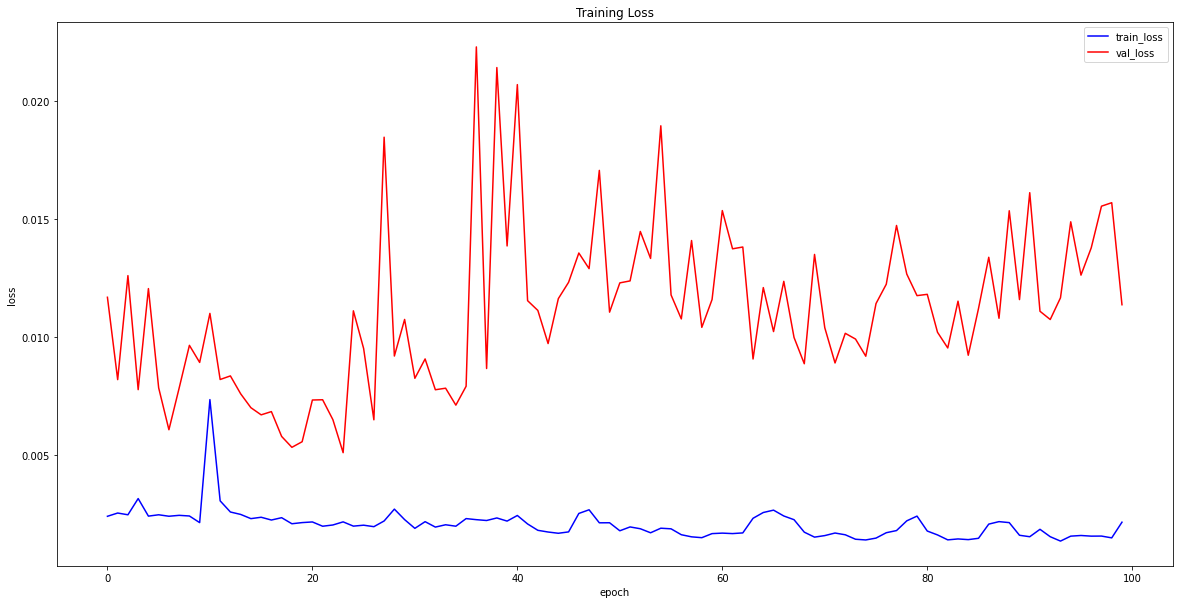

In [122]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [123]:
from keras.models import load_model
model = load_model('/content/best-model-cabbage.h5')

Train Data *평가*

In [124]:
model.evaluate(trainX, trainY, batch_size=a)

204/204 [==============================] - 1s 3ms/step - loss: 0.0019 - mae: 0.0310


[0.0018876452231779695, 0.031016215682029724]

In [125]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 2ms/step


In [126]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1428, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1428, 1)
(1428, 1)


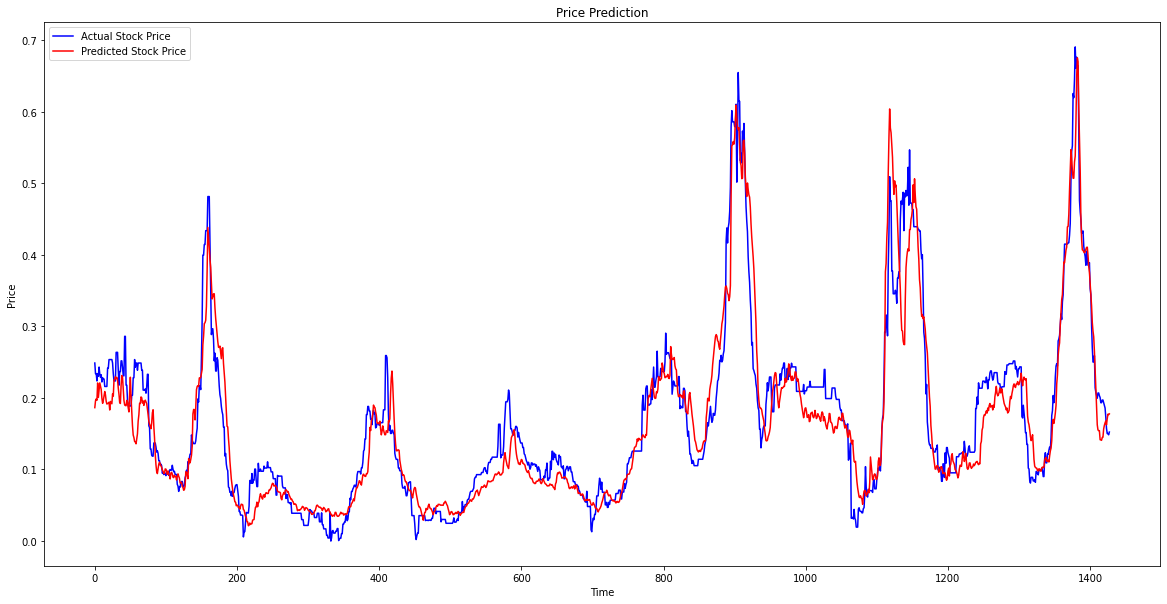

In [127]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [128]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1428, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[3636.1414]
 [3742.6855]
 [3772.9058]
 ...
 [3534.3132]
 [3527.0742]
 [3538.6267]] (1428, 1)
[[4333.]
 [4167.]
 [4167.]
 ...
 [3232.]
 [3212.]
 [3255.]] (1428, 1)


In [129]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

484.5749620382283

In [130]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

345.5061854087338

Val Date 평가


In [131]:
model.evaluate(validX, validY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0427


[0.005102522671222687, 0.04268584027886391]

In [132]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


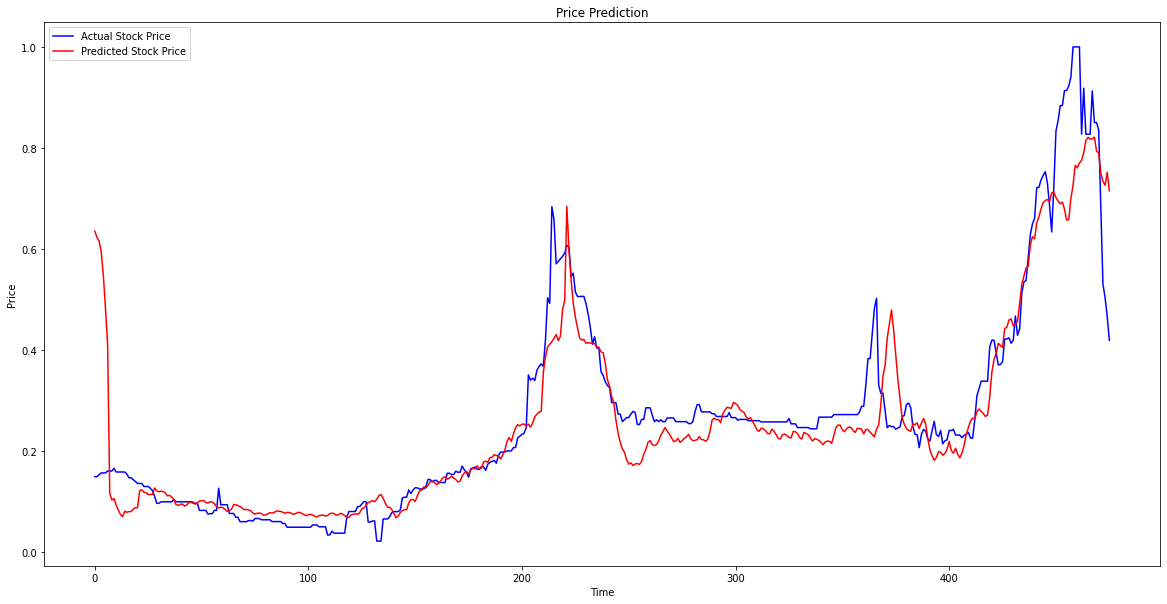

In [133]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (476, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [134]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (476, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[ 8651.784 ]
 [ 8516.287 ]
 [ 8435.982 ]
 [ 8193.32  ]
 [ 7671.6934]
 [ 6947.218 ]
 [ 6147.2695]
 [ 2847.0364]
 [ 2696.811 ]
 [ 2731.0469]
 [ 2588.073 ]
 [ 2477.489 ]
 [ 2376.535 ]
 [ 2329.9568]
 [ 2450.5947]
 [ 2426.3936]
 [ 2440.825 ]
 [ 2441.2166]
 [ 2495.098 ]
 [ 2530.2517]
 [ 2526.1282]
 [ 2905.2734]
 [ 2925.4204]
 [ 2868.4194]
 [ 2858.8577]
 [ 2818.821 ]
 [ 2819.1887]
 [ 2826.5444]
 [ 2965.3   ]
 [ 2904.0596]
 [ 2878.9497]
 [ 2895.4895]
 [ 2883.24  ]
 [ 2857.1243]
 [ 2789.4934]
 [ 2801.1929]
 [ 2767.3433]
 [ 2709.3918]
 [ 2595.4785]
 [ 2578.012 ]
 [ 2601.5417]
 [ 2610.467 ]
 [ 2563.157 ]
 [ 2584.5317]
 [ 2639.8557]
 [ 2647.2524]
 [ 2656.3328]
 [ 2604.9692]
 [ 2629.1016]
 [ 2677.5393]
 [ 2680.484 ]
 [ 2685.5452]
 [ 2636.2048]
 [ 2631.9146]
 [ 2657.7039]
 [ 2654.4822]
 [ 2616.832 ]
 [ 2548.7246]
 [ 2522.276 ]
 [ 2539.8535]
 [ 2527.561 ]
 [ 2491.5737]
 [ 2444.765 ]
 [ 2462.107 ]
 [ 2493.0198]
 [ 2596.4055]
 [ 2594.6743]
 [ 2574.8262]
 [ 2552.8171]
 [ 2518.0024]
 [ 2482.6543]
 [ 249

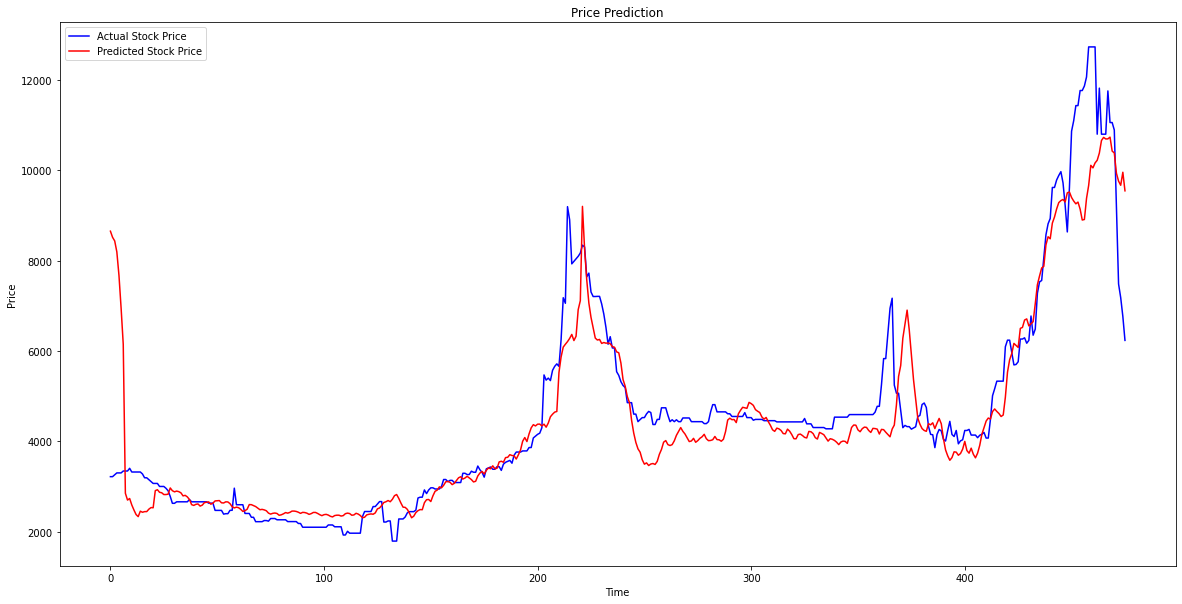

In [135]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [136]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

936.9482165811032

In [137]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

537.6831536813944

Test Data 평가

In [138]:
model.evaluate(testX, testY, batch_size=a)

68/68 [==============================] - 0s 3ms/step - loss: 0.0072 - mae: 0.0579


[0.007241108920425177, 0.05791404843330383]

In [139]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

68/68 [==============================] - 0s 2ms/step


(476, 1)
(476, 1)


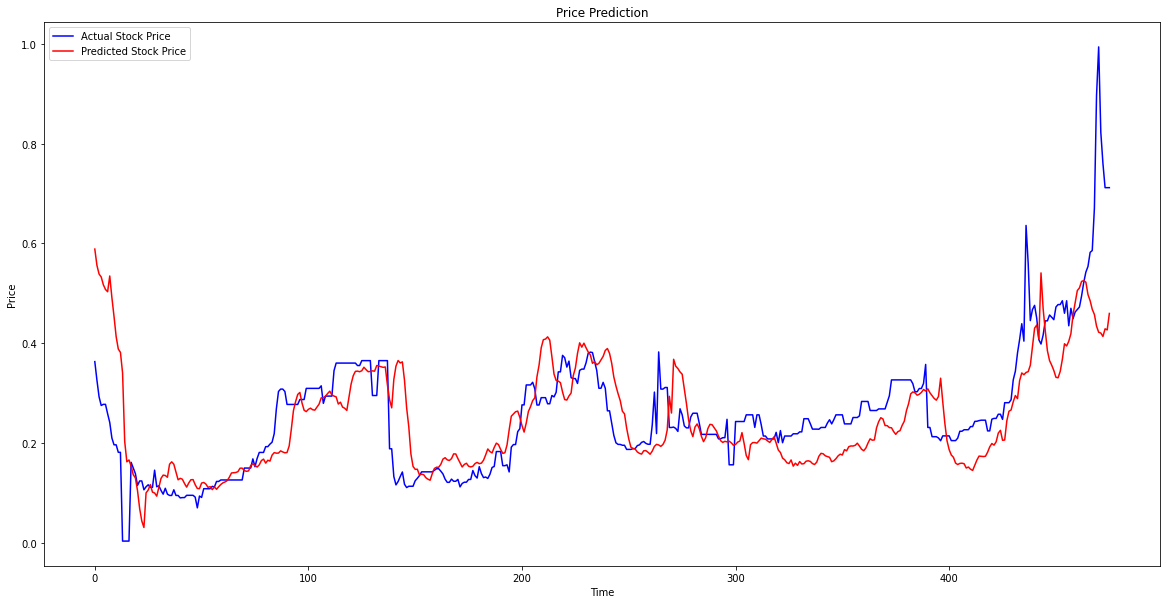

In [140]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (476, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [141]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (476, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[8135.7427]
 [7770.2925]
 [7575.815 ]
 [7510.2183]
 [7335.444 ]
 [7230.34  ]
 [7179.5806]
 [7532.6006]
 [7048.0166]
 [6624.1343]
 [6171.394 ]
 [5894.2627]
 [5820.278 ]
 [5360.949 ]
 [3822.557 ]
 [3367.4124]
 [3408.3784]
 [3270.9702]
 [3077.3376]
 [3007.2927]
 [2720.5916]
 [2319.9849]
 [2040.3374]
 [1894.4672]
 [2670.8596]
 [2734.3105]
 [2856.7063]
 [2687.2942]
 [2667.9268]
 [2598.032 ]
 [2794.5125]
 [2995.5718]
 [3068.6638]
 [3060.238 ]
 [3020.5586]
 [3312.9958]
 [3366.5176]
 [3312.2605]
 [3135.0908]
 [2963.6096]
 [2996.6917]
 [2976.6206]
 [2881.1064]
 [2799.3447]
 [2894.035 ]
 [2965.6255]
 [2968.167 ]
 [2854.3538]
 [2769.0059]
 [2764.9546]
 [2890.6711]
 [2904.004 ]
 [2868.7969]
 [2795.2573]
 [2809.652 ]
 [2743.5803]
 [2802.95  ]
 [2751.069 ]
 [2807.961 ]
 [2859.3682]
 [2896.6255]
 [2915.887 ]
 [2946.5374]
 [3022.6501]
 [3117.2122]
 [3122.6748]
 [3127.391 ]
 [3145.4443]
 [3224.1372]
 [3225.002 ]
 [3170.0461]
 [3154.1533]
 [3163.1643]
 [3283.5999]
 [3324.1824]
 [3283.4417]
 [3250.4294]

In [142]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

1024.6832315362599

In [143]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

688.8566430356323

예측방법

In [144]:
minX1 = np.array(dataX[0:7])
minX2 = np.array(dataX[0:8])
minX3 = np.array(dataX[0:2380])
minX4 = np.array(dataX[0:train_size])

In [145]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

204/204 [==============================] - 1s 3ms/step


In [90]:
predicted_price_min1[0]

array([[0.24257636],
       [0.2127758 ],
       [0.19604716],
       [0.19285223],
       [0.17866859],
       [0.17391121],
       [0.19723114]], dtype=float32)

In [91]:
predicted_price_min2[0]

array([[0.19398737],
       [0.19696312],
       [0.19743334],
       [0.20653376],
       [0.19991168],
       [0.20356661],
       [0.23556557]], dtype=float32)

In [92]:
predicted_price_min3[0]

array([[0.27939177],
       [0.27981317],
       [0.27133626],
       [0.27306294],
       [0.26727262],
       [0.27159923],
       [0.2972232 ]], dtype=float32)

In [93]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[1837.2285],
       [1756.8563],
       [1711.7391],
       [1703.1224],
       [1664.8691],
       [1652.0386],
       [1714.9324]], dtype=float32)